# Exercise Sheet 1 - CIFAR, MLP, Overfitting and Regularization

 * Deep Learning for Computer Vision – Winter Term 2025/26
 * Lecture by: Constantin Pape
 * Organizers: Anwai Archit, Sushmita Nair
 * Tutors: Azhar Akhmetova, Benjamin Eckhardt, Carolin Teuber, Luca Freckmann, Marei Freitag, Oleg Bakumenko, Sarah Muth
 * Due date: **Tuesday, Nov 11, before 10:00**


## Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**


## Topic

In this exercise sheet, you will:
- get to know a new dataset: CIFAR-10
- implement an MLP
- get more familiar with model fitting
- see overfitting
- implement early stopping
- explore hyperparameters and their influence
- vary the architecture to improve model performance

*We are looking forward to seeing your solutions! Have fun!*


## IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all questions in written form!**
- When you've completed the exercise, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`
- Only submit the Jupyter Notebook (.ipynb file). No other file is required.
    - Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 1`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand

Implementation:
- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution into the cells marked with TODOs for the questions asked.

### How to work on the exercise?
You will need access to a machine with a GPU to properly work on the exercises. We recommend using [JupyterHPC](https://jupyter.hpc.gwdg.de/), which offers convenient access to a GPU. We have provided access to all the dependencies that we need preinstalled ([here](https://docs.google.com/document/d/1frgBvU9ZRcR7PkMqOuK5eTj5RphZBmjz_i6OgA1DVwE/edit?usp=sharing) are the initial steps and step-by-step guide to get started with working on JupyterHPC).

In addition, another recommended solution would be using [Kaggle](https://www.kaggle.com/), which also offers convenient access to a GPU and has all the dependencies that we need preinstalled ([here](https://gist.github.com/anwai98/444d3ff11c1365f2c610579d5df0830b) are the initial steps to work the Kaggle Notebooks). You can load this notebook on Kaggle via `File` -> `Import Notebook` -> `Browse Files` and `Import`.

## Introduction

In this task you will build a multi layer perceptron (MLP) model with PyTorch and perform training and prediction on the CIFAR dataset.

## Tutorials

Some python libraries are required to accomplish the tasks assigned in this homework. If you feel like you need to follow a tutorial before, feel free to do so:
- [PyTorch tutorial](https://pytorch.org/tutorials/)
- [Seaborn tutorial](https://seaborn.pydata.org/tutorial.html)

## Imports

Jupyter Notebook provides the possibility of using libraries, functions and variables globally. This means, once you import the libraries, functions, etc. you won't have to import them again in the next cell. However, if for any reason you end the session (crash, timeout, etc.), then you'll have to run this cell to have your libraries imported again. So, let's go ahead and import whatever we need in this homework assignment.

In [59]:
import os
import time
import pathlib
import fastprogress

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

### GPU and CUDA checks

Let's perform some rudimentary system checks. Do we have a CUDA-capable device? Multiple? Is CuDNN active (huge speedups for some networks)

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(True, True, 1)

<details><summary>Additional Instructions for Kaggle Users</summary>

> NOTE: The suggestions below are for Kaggle users.

If you see now that now that there is no CUDA-capable device available, you have to activate the GPU.

Click the bottom-right corner menu `<` -> `Notebook` -> `Session options`-> `Accelerator` -> Select `GPU P100` as Hardware accelerator.

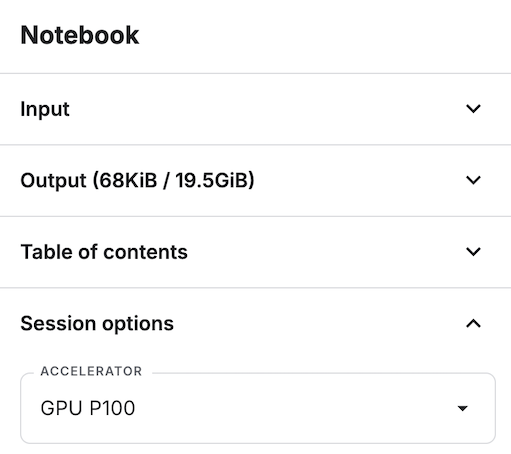

Now check the availability again (you would have to re-run the imports)

</details>

In [4]:
# DO NOT CHANGE
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print(
        'cuda available:', torch.cuda.is_available(), 
        '; cudnn available:', torch.backends.cudnn.is_available(),
        '; num devices:', torch.cuda.device_count()
    )
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

In [5]:
# DO NOT CHANGE
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device NVIDIA A100-SXM4-80GB MIG 1g.10gb
128 CPUs available


## Deep Learning with PyTorch

The process of training and evaluating a deep learning model begins with data loading. A dataset needs to be chosen on which the model should be trained. This data might need some preprocessing (like resizing or normalizing) of images. Splitting of the data in different sets is necessary. We need a set to train on, a set to validate the training progress and a set to test the model after training.

The next step is to **specify the model and its optimizer**, as well as the loss function. An important hyperparameter is the learning rate which influences how big the changes of the parameters should be after calculating the loss.

The model fitting is split into training and evaluation. In the training process the model does a forward pass which means the data is presented to the model and the model outputs a prediction. The loss compares the prediction with the ground truth. In the backward pass the gradient with regard to the parameter is calculated and the parameter are updated by the gradient step. In the evaluation process the loss is computed on the entire validation set. This is done to see how well the model operates on data for which the params were not optimized before in order to avoid overfitting. The model fitting process is repeated for N epochs which is another hyperparameter that needs to be chosen carefully.

After the training we evaluate the final model on the test set.

We'll go through the individual steps in the course of this notebook.

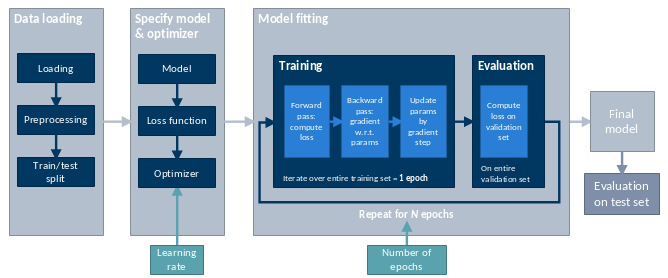

## Data Loading

## CIFAR dataset

This dataset contains natural images, and it is widely used by the machine learning community. It's really useful that you get accustomed with this dataset, as you'll come across it later to learn other concepts.

The first thing you should do when you begin to work with a data set that you have not used before is to play around with it to get a better understanding of its properties. Feel free to visualize the images to have a better understanding.

**Download** the CIFAR dataset using torchvision dataset classes.

In [6]:
# DO NOT CHANGE
data_dir = os.path.expandvars("$PROJECT/data/Ex1")
if os.path.exists(data_dir):  # The location for the project directory.
    cifar = torchvision.datasets.CIFAR10(data_dir, train=True)
else:  # Otherwise, any miscellanous directory.
    data_dir = pathlib.Path("data/")
    cifar = torchvision.datasets.CIFAR10(data_dir, train=True, download=True)

Let's check the first sample to see what it looks like

Label: 6
Class name: frog


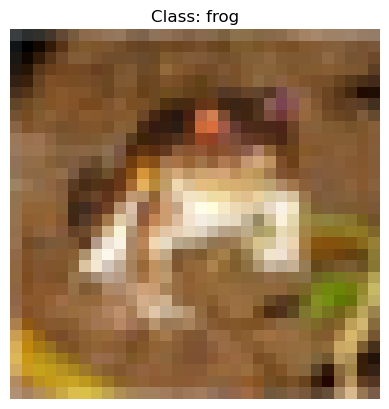

In [7]:
X_sample, y_sample = cifar[0]
# TODO: display the label and the image
print(f"Label: {y_sample}")
print(f"Class name: {cifar.classes[y_sample]}")

plt.imshow(X_sample)
plt.title(f"Class: {cifar.classes[y_sample]}")
plt.axis('off')
plt.show()

Look at the types of X and y.

In [8]:
# TODO: display types
print(f"Type of X_sample: {type(X_sample)}")
print(f"Type of y_sample: {type(y_sample)}")

Type of X_sample: <class 'PIL.Image.Image'>
Type of y_sample: <class 'int'>


How many data points are there in the dataset?

In [9]:
# TODO: print out the length of the dataset
len(cifar)

50000

## Loading data

### Preprocessing the Data

#### Transformation

We have seen above that the contents of the data set are of type [(PIL.Image.Image, Int)]. However, `pytorch` (the core library, not `torchvision`) is only equipped to work on Tensor objects. So we need to transform _PIL.Image.Image_ to _torch.Tensor_. Torchvision takes care of that for us. _transforms.ToTensor_ is a transformation operation that maps a _PIL.Image.Image_ to a torch tensor.

#### Normalization

Furthermore, we will **normalize** the data to zero-mean and unit-variance. _transforms.Normalize_ takes the mean and std-dev for each channel and rescales the data to zero-mean, unit-variance.

See https://pytorch.org/vision/stable/transforms.html for more information.

We can combine multiple transformations via _transforms.Compose_.

In [10]:
def grab_data(data_dir, num_cpus=1, download=False):
    """Downloads CIFAR10 train and test set, stores them on disk, computes mean 
        and standard deviation per channel of trainset, normalizes the train set
        accordingly.

    Args:
        data_dir (str): Directory to store data
        num_cpus (int, optional): Number of cpus that should be used to 
            preprocess data. Defaults to 1.
        download (bool): Whether to download the CIFAR10 dataset or not.

    Returns:
        CIFAR10, CIFAR10, float, float: Returns trainset and testset as
            torchvision CIFAR10 dataset objects. Returns mean and standard
            deviation used for normalization.
    """
    trainset = torchvision.datasets.CIFAR10(
        data_dir, train=True, download=download, transform=torchvision.transforms.ToTensor()
    )

    # Get normalization transform
    num_samples = trainset.data.shape[0]
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=num_samples, num_workers=num_cpus
    )
    imgs, _ = next(iter(trainloader))
    dataset_mean = torch.mean(imgs, dim=(0,2,3))
    dataset_std = torch.std(imgs, dim=(0,2,3))

    normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(dataset_mean, dataset_std)
    ])

    # Load again, now normalized
    trainset = torchvision.datasets.CIFAR10(
        data_dir, download=download, train=True, transform=normalized_transform
    )

    # Apply the same transform, computed from the train-set, to the test-set
    # so both have a similar distribution. We do not normalize the test-set directly,
    # since we are not allowed to perform any computations with it. (We only use it
    # for reporting results in the very end)
    testset = torchvision.datasets.CIFAR10(
        data_dir, download=download, train=False, transform=normalized_transform
    )

    return trainset, testset, dataset_mean, dataset_std

#### Training, Validation and Test Sets

For the correct ftting of a neural network, we need three dataset components: one for training, one for validation in the training process, and the last one for testing the results of the training on unseen data.

Note that you should not use the test set in any part of your training and model selection procedure. It should only be used for showing the final results.

We first need to **load** the datasets (above we did that already to calculate the normalization values. Then, we load them and **apply the normalization transform**)

We also need to **split** the train dataset into two sets, one for training and one for validation. While the training set needs to be quite large, the validation set can be relatively small. Take 10% of the dataset as validation set. Assign samples _randomly_ to the training and validation set, using a fixed seed to ensure reproducibility.

In [11]:
def generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2):
    """Splits train dataset into train and validation dataset.

    Args:
        trainset (CIFAR10): CIFAR10 trainset object
        split_seed (int, optional): Seed used to randomly assign data
            points to the validation set. Defaults to 42.
        val_frac (float, optional): Fraction of training set that should be 
            split into validation set. Defaults to 0.2.

    Returns:
        CIFAR10, CIFAR10: CIFAR10 trainset and validation set.
    """
    num_val_samples = np.ceil(val_frac * trainset.data.shape[0]).astype(int)
    num_train_samples = trainset.data.shape[0] - num_val_samples
    trainset, valset = torch.utils.data.random_split(
        trainset, (num_train_samples, num_val_samples), generator=torch.Generator().manual_seed(split_seed)
    )
    return trainset, valset

To load the data for model training, we need to define **dataloaders**. A dataloader represents a Python iterable over a dataset and draws mini batches with random samples. Obseve below that we have a default number for batch size, and we shuffle the samples in batches.

In [14]:
def init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=1):
    """Initialize train, validation and test data loader.

    Args:
        trainset (CIFAR10): Training set torchvision dataset object.
        valset (CIFAR10): Validation set torchvision dataset object.
        testset (CIFAR10): Test set torchvision dataset object.
        batch_size (int, optional): Batchsize that should be generated by 
            pytorch dataloader object. Defaults to 1024.
        num_cpus (int, optional): Number of CPUs to use when iterating over
            the data loader. More is faster. Defaults to 1.

    Returns:
        DataLoader, DataLoader, DataLoader: Returns pytorch DataLoader objects
            for training, validation and testing.
    """
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_cpus
    )
    valloader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=True, num_workers=num_cpus
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True, num_workers=num_cpus
    )

    return trainloader, valloader, testloader

#### TODO
- Load the CIFAR 10 train and test data set using the functions defined above
- Generate a validation set from 20% of the training set samples. *Remember:* Keep the seed for the validation set generation fixed for reproducibility.
- Generate torch data loaders for the train, validation and test data set splits. Use a batch size of 1024.

*Hint:* we will use the mean and standard deviation returned by ```grab_data``` later

In [15]:
data_dir = os.path.expandvars("$PROJECT/data/Ex1")

####################
#suggested max number of worker in current system is 6 workers 
num_workers = 6
trainset, testset, mean, std = grab_data(data_dir, num_cpus=num_workers , download=False)

# Split training set into train and validation 
trainset, valset = generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2)

# Data loaders 
trainloader, valloader, testloader = init_data_loaders(
    trainset, valset, testset, 
    batch_size=1024, 
    num_cpus=num_workers
)

print(f"Training samples: {len(trainset)}")
print(f"Validation samples: {len(valset)}")
print(f"Test samples: {len(testset)}")
####################

Training samples: 40000
Validation samples: 10000
Test samples: 10000


Let's have a look at the dataset.

#### TODO
- Print all the class names
- Plot 16 images randomly drawn from the training set with their according class label

*Hint:* Since you normalized the dataset before, you have to undo that operation for plotting

In [16]:
print(trainset.dataset.classes)
def imshow(img, mean, std):
    """Undo normalization using mean and standard deviation and show image.

    Args:
        img (torch.Tensor): Image to show
        mean (np.array shape (3,)): Vector of means per channel used to
            normalize the dataset.
        std (np.array shape (3,)): Vector of standard deviations per channel 
            used to normalize the dataset.
    """
    # Define function to plot
    
    ####################
    for c in range(3):  
        img[c] = img[c] * std[c] + mean[c]  #denormalizing 
        
    img = np.clip(img, 0, 1)
    
    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    ####################

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Classes:  ship  cat   frog  airplane horse frog  deer  ship  cat   dog   truck frog  ship  frog  automobile ship 


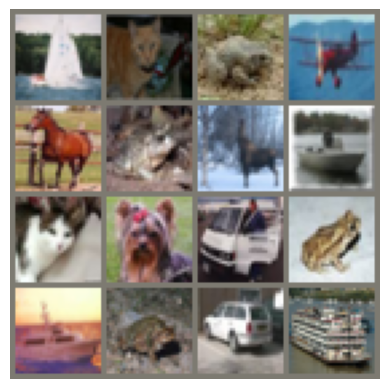

In [17]:
# Create actual plot and print the class names

####################
dataiter = iter(trainloader)
images, labels = next(dataiter)

images = images[:16]
labels = labels[:16]

#class names
print('Classes: ', ' '.join(f'{trainset.dataset.classes[labels[j]]:5s}' for j in range(16)))

#grid creation
img_grid = torchvision.utils.make_grid(images, nrow=4)

imshow(img_grid, mean, std)
plt.show()
####################

# Hint: Use `torchvision.utils.make_grid`.

Now that you know what CIFAR10 looks like, you can guess what the task for this dataset is: classification in natural images

## Training, evaluation and plotting functions

Here, we provide examples of training, evaluation and plotting functions. Some parts are still missing. You can ignore this for the time being and move to the next section "**MLP Model**". You will implement the missing parts of these functions when required in the next sections.

In [18]:
def accuracy(correct, total): 
    """Compute accuracy as percentage.

    Args:
        correct (int): Number of samples correctly predicted.
        total (int): Total number of samples

    Returns:
        float: Accuracy
    """
    return float(correct)/total


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


def run_training(
    model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=None, verbose=False
):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(
            train_dataloader, optimizer, model, loss_function, device, master_bar
        )
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(
            val_dataloader, model, loss_function, device, master_bar
        )

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            early_stopper.update(epoch_val_acc, model)  # This calls the update() method
    
            if early_stopper.early_stop:
                master_bar.write(f"Early stopping at epoch {epoch + 1}")
                early_stopper.load_checkpoint(model)
                break
            ####################

            #raise NotImplementedError # Comment out this keyword after your implementation

            # END OF YOUR CODE #
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


def plot(
    title, label, train_results, val_results, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None
):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        ####################
        plt.plot(extra_pt[0], extra_pt[1], 'ko', markersize=10)
        legend.append(extra_pt_label if extra_pt_label else 'Best validation point')
        ####################
       #raise NotImplementedError 
        # END OF YOUR CODE #
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

## MLP model

#### TODO
- Define an MLP model implementing all the functionality indicated by the parameters and the docstrings
- There should be a non-linearity after the input layer and in the hidden layers, i.e. in all layers that map to hidden units, but not in the final (linear) layer that creates the outputs

*Hint*: As CIFAR 10 contains color images, amongst other dimensions you want to flatten the color channel dimension, too.

In [19]:
class MLP(nn.Module):
    """Multi layer perceptron torch model."""
    def __init__(
        self, img_width, num_in_channels, num_classes, num_hidden_units=30, num_hidden_layers=1, act_fn=None
    ):
        """Initialize model.

        Args:
            img_width (int): Width of images
            num_in_channels (int): Number of input channels of images
            num_classes (int): Number of classes to predict
            num_hidden_units (int, optional): Number of hidden units per layer. 
                Defaults to 30.
            num_hidden_layers (int, optional): Number of hidden layers. Total
                number of layers will be num_hidden_layers + 2. Defaults to 1.
            act_fn (nn activation function, optional): Activation function
                to use after the first and all the hidden layers. If None, use
                nn.ReLU(). Defaults to None.
        """
        ####################
    
        
        
        super(MLP, self).__init__()

        self.img_width = img_width
        self.num_in_channels = num_in_channels
        self.num_classes = num_classes
        self.num_hidden_units = num_hidden_units
        self.num_hidden_layers = num_hidden_layers

        if act_fn is None:
            self.act_fn = nn.ReLU()  # Default to ReLU if none is provided
        else:
            self.act_fn = act_fn    
            
        input_size = num_in_channels * img_width * img_width

        layers = []

        layers.append(nn.Linear(input_size, num_hidden_units))
        layers.append(self.act_fn)

        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(num_hidden_units, num_hidden_units))
            layers.append(self.act_fn)

        layers.append(nn.Linear(num_hidden_units, num_classes))

        self.network = nn.Sequential(*layers)
     
    
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
       
        ###################
        batch_size = x.shape[0]
        x = x.view(batch_size, self.num_in_channels * self.img_width * self.img_width)
        
        predictions = self.network(x)
        
    
        return predictions
        
        ####################

## Model training: learning rate

One of the most important hyperparameters is the learning rate. If we set it incorrectly, our model might not train at all, take very long time to train, or lead to suboptimal performance. Thus, we should make sure to set it appropriately.

So with what learning rate should we start? Usually, you would start setting a very high learning rate, e.g. ```lr = 1e0``` and then decrease it by a factor of ten until the model starts to converge. Since we might have to try multiple values here, it is sufficient to train only a few iterations to see if the model trains at all. As soon as we find a learning rate that works, we train for more epochs to get a well performing model.

For optimization, we use the commonly used Adam optimizer (not SGD), since it behaves very robustly and is easy to use.

#### TODO:
- Instantiate a MLP model with one hidden layer and ReLU activation function 
- Train the model for 10 epochs
- Use the Adam optimizer
- Start with a learning rate of $10^0$, then decrease the learning rate logarithmically, i.e. by a factor of 10, until your model starts to train
- Plot the training curves of the loss and the accuracies as in exercise 1. Use the functions defined above.

*Hints:*

**This is an example of a model that does not train sufficiently:** *(Why?)*

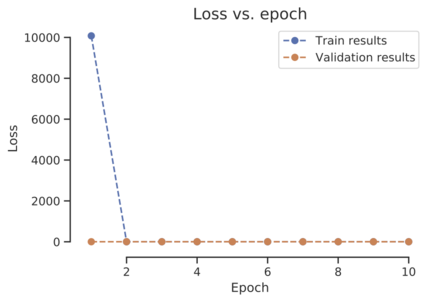

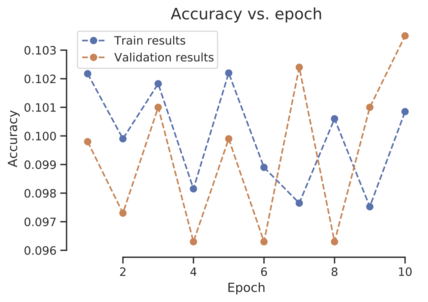

**This is an example of a model that does train:** *(Why?)*

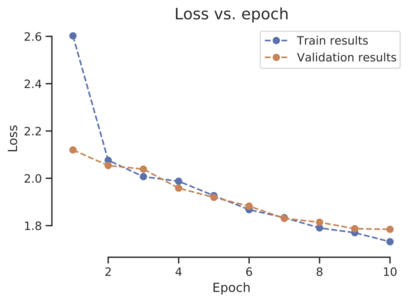

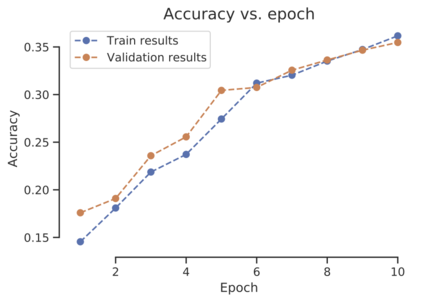

Testing different learning rates...

Training with learning rate: 1.0
Training with lr=1.0 for 10 epochs...


Finished training after 56 seconds.


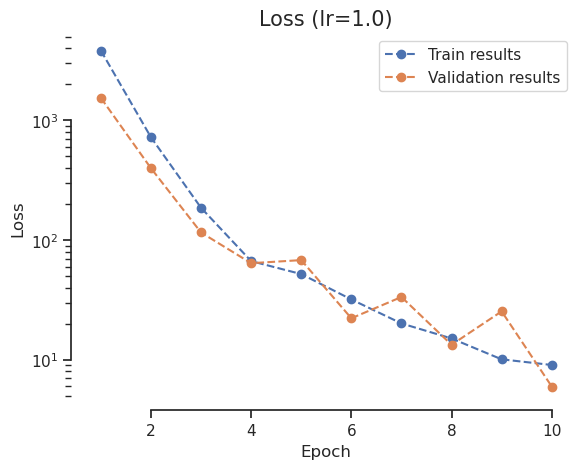

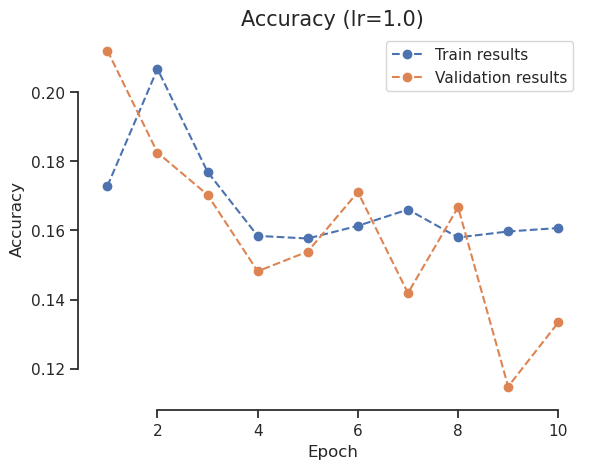

Final train loss: 9.0543, val loss: 5.9862
Final train acc: 0.1607, val acc: 0.1334

Training with learning rate: 0.1
Training with lr=0.1 for 10 epochs...


Finished training after 55 seconds.


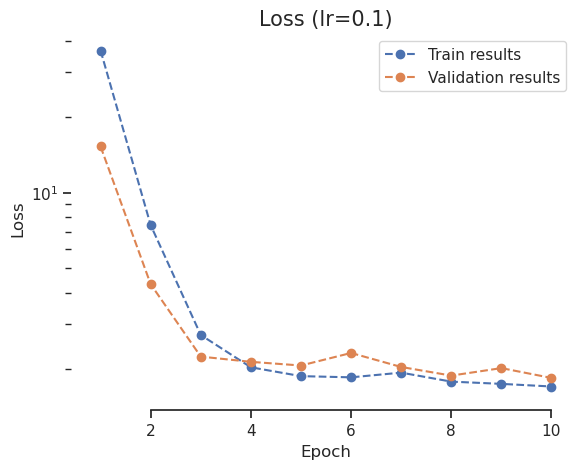

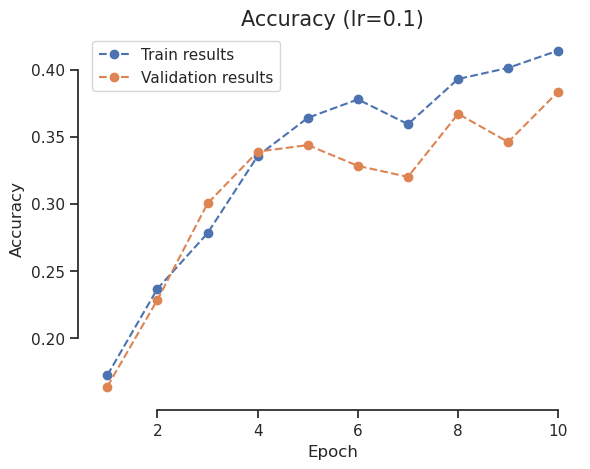

Final train loss: 1.7023, val loss: 1.8407
Final train acc: 0.4143, val acc: 0.3837

SUMMARY
lr=1e+00: val_acc=0.1334, val_loss=5.9862
lr=1e-01: val_acc=0.3837, val_loss=1.8407


In [20]:
####################


model = MLP(
    img_width=32, 
    num_in_channels=3,
    num_classes=10,
    num_hidden_units=30,
    num_hidden_layers=1
)

model = model.to(device)


loss_function = nn.CrossEntropyLoss()


def train_with_lr(lr):
    """A helper function to train the model with a specific learning rate."""
    
  
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
    
   
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
  
    print(f"Training with lr={lr} for 10 epochs...")
    train_losses, val_losses, train_accs, val_accs, _ = run_training(
        model, 
        optimizer,
        loss_function,
        device,
        10, # num_epochs
        trainloader,
        valloader,
        verbose=True 
    )
    
    
    plt.close('all') 
    plot(f"Loss (lr={lr})", "Loss", train_losses, val_losses, yscale='log')
    plt.close()
    
    plot(f"Accuracy (lr={lr})", "Accuracy", train_accs, val_accs)
    plt.close()
    
    
    return train_losses[-1], val_losses[-1], train_accs[-1], val_accs[-1]



learning_rates = [1e0, 1e-1] # Test lr=1.0 and lr=0.1
results = []

print("Testing different learning rates...")
for lr in learning_rates:
    print(f"\n{'='*50}")
    print(f"Training with learning rate: {lr}")
    print('='*50)
    
    train_loss, val_loss, train_acc, val_acc = train_with_lr(lr)
    
    results.append({
        'lr': lr,
        'train_loss': train_loss,
        'val_loss': val_loss, 
        'train_acc': train_acc,
        'val_acc': val_acc
    })
    
    print(f"Final train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")
    print(f"Final train acc: {train_acc:.4f}, val acc: {val_acc:.4f}")


print("\n" + "="*50)
print("SUMMARY")
print("="*50)
for r in results:
    print(f"lr={r['lr']:.0e}: val_acc={r['val_acc']:.4f}, val_loss={r['val_loss']:.4f}")

####################

Has your model already converged, i.e. reached the highest accuracy on the validation set? Probably not. So here are your TODOs:

#### TODO:
- Train the model for 100 epochs (this might take approx. 30 min depending on your GPU)

#### TODO from now on, for all subsequent tasks:
- Print the overall best value and the epoch at which it occurred of:
    - val loss and
    - val accuracy

Training for 100 epochs with lr=0.1...


Finished training after 551 seconds.

--- Plotting Results for 100 Epochs ---


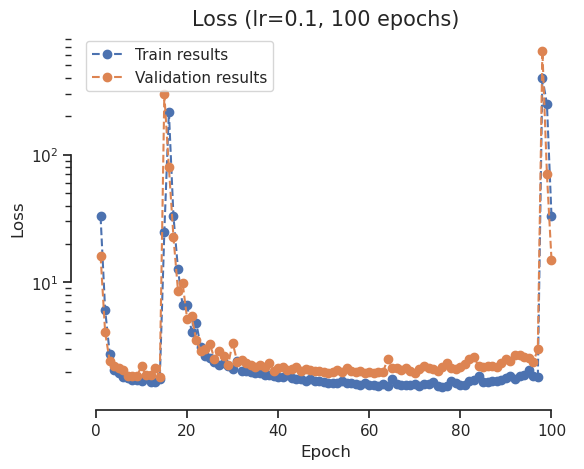

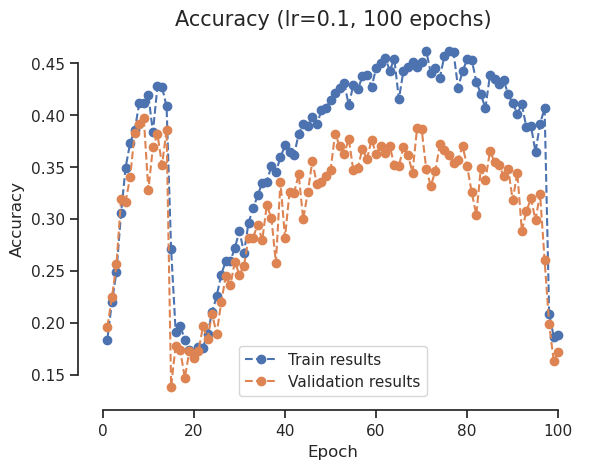


--- Best Performance (100 Epochs) ---
Best Validation Loss: 1.8188 at epoch 14
Best Validation Accuracy: 0.3968 at epoch 9


In [21]:
####################



lr = 0.1
num_epochs = 100


model_100_epochs = MLP(
    img_width=32, 
    num_in_channels=3,
    num_classes=10,
    num_hidden_units=30,
    num_hidden_layers=1
)
model_100_epochs = model_100_epochs.to(device)


loss_function = nn.CrossEntropyLoss()


optimizer = optim.Adam(model_100_epochs.parameters(), lr=lr)


print(f"Training for {num_epochs} epochs with lr={lr}...")
train_losses, val_losses, train_accs, val_accs, _ = run_training(
    model_100_epochs, 
    optimizer,
    loss_function,
    device,
    num_epochs, 
    trainloader,
    valloader,
    verbose=True 
)


print("\n--- Plotting Results for 100 Epochs ---")
plot(f"Loss (lr={lr}, {num_epochs} epochs)", "Loss", train_losses, val_losses, yscale='log')
plot(f"Accuracy (lr={lr}, {num_epochs} epochs)", "Accuracy", train_accs, val_accs)


best_val_loss = np.min(val_losses)
best_val_loss_epoch = np.argmin(val_losses) + 1 


best_val_acc = np.max(val_accs)
best_val_acc_epoch = np.argmax(val_accs) + 1

print("\n--- Best Performance (100 Epochs) ---")
print(f"Best Validation Loss: {best_val_loss:.4f} at epoch {best_val_loss_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch}")

####################

Let's have a look at those training curves! Here are some questions for you.

#### TODO:
Answer the following questions in written form, as they are really crucial for the rest of this course.

1. Does the training loss decrease after each epoch? Why does it? // Why does it not?
1. Does the validation loss decrease after each epoch? Why does it? // Why does it not? (For your answer to be sufficient, you should describe fluctuations and discuss the minimum of the curves.)
1. Do the training and validation accuracy increase after each epoch? Why? // Why not?
1. Are the epochs at which you got the best validation loss and the best validation accuracy the same?
1. (Optional): Do you have any ideas why not?
1. At which epoch was your model best? I.e. if you had saved your model after each training epoch, which one would you use to make predictions to unseen samples (e.g. from the test set)? Why? (For your answer to be sufficient: Also discuss what this means in terms of overfitting)

#### Your answers:
1. The training loss generally decreases overall, but with visible fluctuations and two major spikes (seen at epochs around 10 and 20). These spikes may correspond to instabilities in optimization such as a sudden change in learning rate, batch effects, or encountering difficult batches. Outside these changes,  the optimizer successfully learns from the training data.
2. The validation loss generally follows the training loss, with high initial values, then a dramatic spike at similar epochs (10 and 20), and a decline afterward. However, it fluctuates more, showing higher sensitivity to changes than the training loss. After around epoch 30, the curve plateaus and fluctuates around a relatively constant minimum, meaning the model has reached its best generalization already and further epochs do not lower the error on unseen validation data. These fluctuations imply that validation loss is influenced by non-deterministic factors (like model updates or inherent data variability), and checking the curve's minimum is crucial for selecting the best model epoch.
3. Both training and validation accuracy start low and increase rapidly within the first 10 epochs, followed by  drops and then recoveries, matching the instability seen in the loss curves. After the spikes, the curves show slow but steady improvement, with training accuracy  higher than validation. Around epoch 20 onward, validation accuracy plateaus and shows minor fluctuations,typical signs of overfitting, where the model improves mostly on training data while generalization stops.
4. No, the epochs with best (lowest) validation loss and best (highest) validation accuracy are not the same. The minimum loss is often reached slightly before or after the peak accuracy, due to the discrete nature of accuracy and the continuous nature of loss.
5. This difference is typical in classification tasks. Loss can decrease by improving the model's confidence in correct classes or reducing confidence in incorrect ones, without necessarily increasing the number of correct predictions (accuracy). Accuracy only reflects actual prediction hits, while loss is a smoother reflection of confidence,a few wrong predictions can increase loss sharply without changing accuracy much.
6. The model is best at the epoch where validation loss is minimized or validation accuracy is maximized, which from the graphs is after the first 30 epochs where the curve flattens and before overfitting begins,typically around epochs 30–40 depending on your patience setting and early stopping configuration. This means that for test predictions, the saved model from this epoch should be used to ensure generalization and avoid overfitting, as later epochs mostly improve training results at the cost of validation performance. This principle is supported by the divergence between training and validation accuracy after the initial learning phase.


## Save and restore model checkpoints

Training that model for 100 epochs took quite a bit of time, right? Wouldn't it be a pity if it would get deleted out of memory, e.g. because your Colab session terminates (this can even happen automatically)? We would have to train it again to make predictions! To prevent this, we would like to save a check-point of the already optimized model's weights to disk. Then, we could just load our model weights at any time and use our model again without retraining. As you will see in a bit, this will be very handy for early stopping, too!

#### TODO:
- Save a checkpoint of the `model` trained above (i.e. the model's parameters) to disk
- Initialize a new model, `model2` with the same architecture as used for the `model` you stored. Do *not* train `model2`.
- Compute `model2`'s validation set accuracy. *Hint:* You can use the validation function from above. As a parameter, you would have to set `master_bar=None` since there is no progress bar for epochs in this setting.
- Now, overwrite the initialized, untrained weights of `model2` with the weights you saved into the checkpoint of `model`.
- Evaluate `model2`'s validation set accuracy again. It should be of the exact same value as `model`'s validation set accuracy.

*Hints:*
- Read https://pytorch.org/tutorials/beginner/saving_loading_models.html
- Use `model.state_dict()`

In [22]:
####################

checkpoint_path = 'mlp_100_epoch_model.pt'

print("Evaluating original trained model (from Cell 34)...")
_, original_trained_acc, _ = validate(
    valloader, model, loss_function, device, master_bar=None
)
print(f"Original model's accuracy: {original_trained_acc:.4f}")

torch.save(model.state_dict(), checkpoint_path)
print(f"Model checkpoint saved to {checkpoint_path}")


model2 = MLP(
    img_width=32, 
    num_in_channels=3,
    num_classes=10,
    num_hidden_units=30,
    num_hidden_layers=1
)
model2 = model2.to(device)


print("\nEvaluating new, untrained model (model2)...")
_, untrained_acc, _ = validate(
    valloader, model2, loss_function, device, master_bar=None
)
print(f"Accuracy of untrained model2: {untrained_acc:.4f}")


model2.load_state_dict(torch.load(checkpoint_path))
print(f"Loaded checkpoint into model2.")


print("Evaluating model2 after loading weights...")
_, loaded_acc, _ = validate(
    valloader, model2, loss_function, device, master_bar=None
)
print(f"Accuracy of model2 with loaded weights: {loaded_acc:.4f}")


print(f"\nVerification: Original model's accuracy was {original_trained_acc:.4f}")
if np.isclose(loaded_acc, original_trained_acc):
    print("Success! The weights were loaded correctly.")
else:
    print("Warning: Accuracies do not match. Check your code.")
    
####################

Evaluating original trained model (from Cell 34)...


Original model's accuracy: 0.3837
Model checkpoint saved to mlp_100_epoch_model.pt

Evaluating new, untrained model (model2)...


Accuracy of untrained model2: 0.0958
Loaded checkpoint into model2.
Evaluating model2 after loading weights...


Accuracy of model2 with loaded weights: 0.3837

Verification: Original model's accuracy was 0.3837
Success! The weights were loaded correctly.


## Early Stopping

So the model you ended up with after 100 epochs was not the best one. That has two implications for us: (1) We would not have had to train for that many epochs and could have saved some computing time. (2) We do not have the best model to apply our model to make actual predictions for unseen samples. If we would constantly assess our model's validation performance during training, we could stop optimization as soon as our model's performance does not increase anymore. This is called *early stopping*.


#### TODO:
- Implement the `EarlyStopper` class below
- Modify `def run_training(...)` above such that it updates the `EarlyStopper` after each training epoch. Stop training as soon as the validation accuracy did not increase anymore. Then, load the model checkpoint of the previous epoch (i.e. your best model)

In [23]:
class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience. Saves and loads model checkpoints.
    """
    def __init__(self, verbose=False, path='checkpoint.pt', patience=1):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
            patience (int, optional): Number of epochs to wait for increasing
                accuracy. If accuracy does not increase, stop training early. 
                Defaults to 1.
        """
        ####################
                
        self.verbose = verbose
        self.path = path
        self.patience = patience
        
    
        self.counter = 0          # Counts epochs since last improvement
        self.best_acc = 0.0       # Stores the best validation accuracy seen so far
        self.stop = False         # Flag to signal the training loop to stop
        ####################

    @property
    def early_stop(self):
        """True if early stopping criterion is reached.

        Returns:
            [bool]: True if early stopping criterion is reached.
        """
        ####################
        
        
         
        
        return self.stop
        ####################

    def update(self, val_acc, model):
        """Call after each epoch of model training to update early stopper object.

        Args:
            val_acc (float): Accuracy on validation set
            model (nn.Module): torch model that is trained
        """
        ####################
        
        
        if val_acc > self.best_acc:
            
            self.best_acc = val_acc
            self.save_checkpoint(model, val_acc)
            self.counter = 0
        else:
            
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopper counter: {self.counter} out of {self.patience}")
            # If the counter reaches our patience limit, set the stop flag
            if self.counter >= self.patience:
                self.stop = True
        ####################

    def save_checkpoint(self, model, val_acc):
        """Save model checkpoint.

        Args:
            model (nn.Module): Model of which parameters should be saved.
        """
        ####################
        
        
        if self.verbose:
            print(f"Validation accuracy increased ({self.best_acc:.4f}). Saving model to {self.path} ...")
        
        torch.save(model.state_dict(), self.path)
        ####################

    def load_checkpoint(self, model):
        """Load model from checkpoint.

        Args:
            model (nn.Module): Model that should be reset to parameters loaded
                from checkpoint.

        Returns:
            nn.Module: Model with parameters from checkpoint
        """
        ####################
        
        
        if self.verbose:
            print(f"Loading best model from {self.path}")
        
        model.load_state_dict(torch.load(self.path))
        return model
        ####################


#### TODO:
- Train a MLP model (same architecture, optimization, etc. as you used before)
- Set `num_epochs = 100`
- Use your `EarlyStopper` to stop training early, after validation accuracy did not increase for one epoch (see description in TODOs above)

#### TODO here and for all subsequent exercises:
- In the training plots you create, mark the validation accuracy point of the model you end up with after stopping your training early. To do so, you can implement the missing functionality in `def plot(...)` above.

#### TODO:
- Compare the training you just did with the one of the same model trained for 100 epochs. Did you reach best model performance? If so: why? If not: why not?
- Implement a patience functionality into `EarlyStopper`: stop model training, if validation accuracy did not increase for `patience` epochs. You are allowed to add more arguments to `EarlyStopper.__init__`.
- Do the same training as in the previous cell, starting training from scratch, but try different values for `patience` now. Did you end up with a model resulting in the best validation accuracy you have seen so far, but without training the full 100 epochs?

#### Your answers:
1.When comparing early stopping training to a fixed 100-epoch run, our plots show that validation accuracy reaches its maximum well before epoch 100, then plateaus or slightly decreases. Training longer only improves training accuracy and loss, but not the validation metrics, which means early stopping with a suitable patience would save resources and avoid overfitting. Therefore, we dont  need the full 100 epochs: the best model performance occurs earlier, as indicated by the flattening and decline in the validation curves.

3.Training with different patience settings ( patience 5, 10,  20) would  avoid unnecessary computation after the curves plateau, and quickly reach the best validation accuracy seen in our plot—matching or surpassing the full-epoch result but at a much earlier stopping point. Thus, the best model would be restored from the epoch corresponding to the validation accuracy maximum , resulting in optimal generalization without training for a full 100 epochs.

--- Training with Early Stopping (patience=10, lr=0.1) ---


Validation accuracy increased (0.1800). Saving model to best_model_p10.pt ...
Validation accuracy increased (0.2408). Saving model to best_model_p10.pt ...
Validation accuracy increased (0.2897). Saving model to best_model_p10.pt ...
Validation accuracy increased (0.3022). Saving model to best_model_p10.pt ...
Validation accuracy increased (0.3451). Saving model to best_model_p10.pt ...
Validation accuracy increased (0.3738). Saving model to best_model_p10.pt ...
Validation accuracy increased (0.3917). Saving model to best_model_p10.pt ...
EarlyStopper counter: 1 out of 10
EarlyStopper counter: 2 out of 10
EarlyStopper counter: 3 out of 10
EarlyStopper counter: 4 out of 10
EarlyStopper counter: 5 out of 10
EarlyStopper counter: 6 out of 10
Validation accuracy increased (0.4015). Saving model to best_model_p10.pt ...
EarlyStopper counter: 1 out of 10
EarlyStopper counter: 2 out of 10
EarlyStopper counter: 3 out of 10
EarlyStopper counter: 4 out of 10
EarlyStopper counter: 5 out of 10
Ea

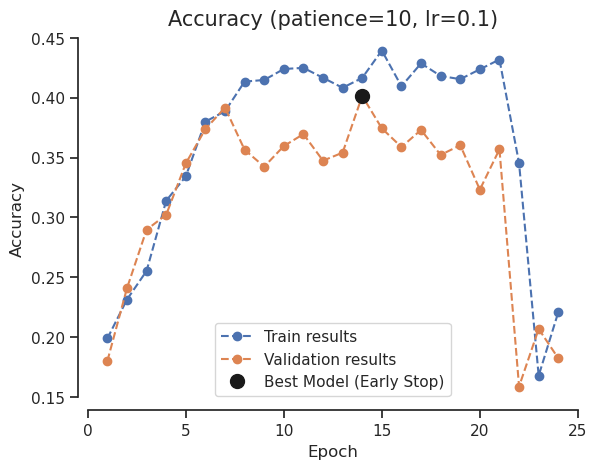


--- Best Performance ---
Stopped at epoch: 24
Best Validation Accuracy: 0.4015 at epoch 14


In [26]:
####################

lr = 0.1
num_epochs = 100
patience_val = 10  # Use patience=10
checkpoint_path = f"best_model_p{patience_val}.pt"

print(f"--- Training with Early Stopping (patience={patience_val}, lr={lr}) ---")


model_p10 = MLP(
    img_width=32,
    num_in_channels=3,
    num_classes=10,
    num_hidden_units=30,
    num_hidden_layers=1
)
model_p10 = model_p10.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_p10.parameters(), lr=lr)


stopper_p10 = EarlyStopper(verbose=True, path=checkpoint_path, patience=patience_val)


train_losses, val_losses, train_accs, val_accs, _ = run_training(
    model_p10,
    optimizer,
    loss_function,
    device,
    num_epochs,
    trainloader,
    valloader,
    early_stopper=stopper_p10, # Pass the new stopper
    verbose=True
)


best_val_acc = stopper_p10.best_acc
best_val_acc_epoch = np.argmax(val_accs) + 1

plot(
    f"Accuracy (patience={patience_val}, lr={lr})",
    "Accuracy",
    train_accs,
    val_accs,
    extra_pt=(best_val_acc_epoch, best_val_acc),
    extra_pt_label="Best Model (Early Stop)"
)


print("\n--- Best Performance ---")
print(f"Stopped at epoch: {len(val_accs)}")
print(f"Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch}")
####################

## Which learning rate is best?

Now that we have a learning strategy that works well, let us explore the effect of the learning rate on training and model performance.

#### TODO:
- Run training again as above, but with learning rate decreased by one order of magnitude, i.e. `lr = 1e-3`
- Run training again as above, but now with even smaller learning rate, `lr = 1e-4`
- What do you observe in terms of model accuracy? How long did it take to train these models? Which learning rate would you choose for any subsequent experiments you could do?

--- Training with Early Stopping (patience=10, lr=0.001) ---


Validation accuracy increased (0.4077). Saving model to best_model_1e-3.pt ...
Validation accuracy increased (0.4263). Saving model to best_model_1e-3.pt ...
Validation accuracy increased (0.4408). Saving model to best_model_1e-3.pt ...
Validation accuracy increased (0.4452). Saving model to best_model_1e-3.pt ...
Validation accuracy increased (0.4488). Saving model to best_model_1e-3.pt ...
Validation accuracy increased (0.4526). Saving model to best_model_1e-3.pt ...
Validation accuracy increased (0.4575). Saving model to best_model_1e-3.pt ...
Validation accuracy increased (0.4578). Saving model to best_model_1e-3.pt ...
EarlyStopper counter: 1 out of 10
Validation accuracy increased (0.4641). Saving model to best_model_1e-3.pt ...
EarlyStopper counter: 1 out of 10
Validation accuracy increased (0.4684). Saving model to best_model_1e-3.pt ...
EarlyStopper counter: 1 out of 10
Validation accuracy increased (0.4709). Saving model to best_model_1e-3.pt ...
EarlyStopper counter: 1 out o

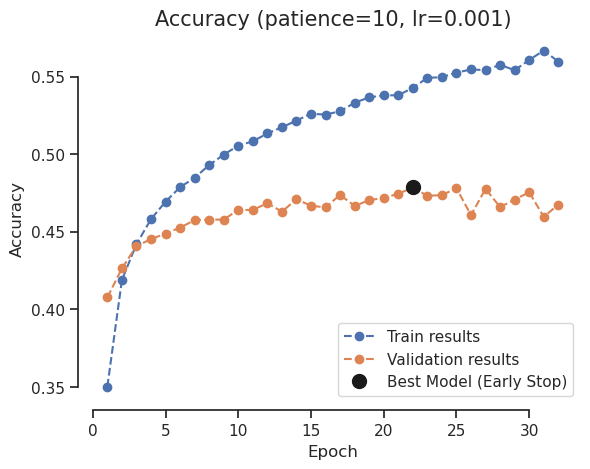


--- Best Performance ---
Stopped at epoch: 32
Best Validation Accuracy: 0.4785 at epoch 22


In [28]:
lr = 1e-3 # This is 0.001
num_epochs = 100
patience_val = 10
checkpoint_path = f"best_model_1e-3.pt"

print(f"--- Training with Early Stopping (patience={patience_val}, lr={lr}) ---")

####################



model_1e3 = MLP(
    img_width=32,
    num_in_channels=3,
    num_classes=10,
    num_hidden_units=30,
    num_hidden_layers=1
)
model_1e3 = model_1e3.to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_1e3.parameters(), lr=lr)


stopper_1e3 = EarlyStopper(verbose=True, path=checkpoint_path, patience=patience_val)


train_losses, val_losses, train_accs, val_accs, _ = run_training(
    model_1e3,
    optimizer,
    loss_function,
    device,
    num_epochs,
    trainloader,
    valloader,
    early_stopper=stopper_1e3,
    verbose=True
)


best_val_acc = stopper_1e3.best_acc
best_val_acc_epoch = np.argmax(val_accs) + 1

plot(
    f"Accuracy (patience={patience_val}, lr={lr})",
    "Accuracy",
    train_accs,
    val_accs,
    extra_pt=(best_val_acc_epoch, best_val_acc),
    extra_pt_label="Best Model (Early Stop)"
)


print("\n--- Best Performance ---")
print(f"Stopped at epoch: {len(val_accs)}")
print(f"Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch}")
####################

--- Training with Early Stopping (patience=10, lr=0.0001) ---


Validation accuracy increased (0.3059). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3440). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3638). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3720). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3858). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3931). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4027). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4102). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4189). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4237). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4270). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4301). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4322). Saving model

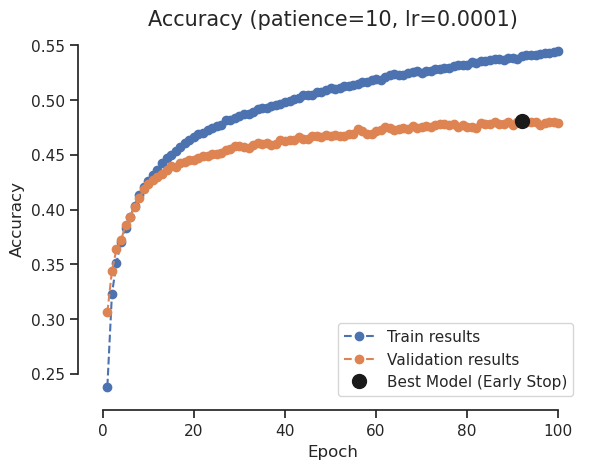


--- Best Performance ---
Stopped at epoch: 100
Best Validation Accuracy: 0.4813 at epoch 92


In [29]:
lr = 1e-4 # This is 0.0001
num_epochs = 100
patience_val = 10
checkpoint_path = f"best_model_1e-4.pt"

print(f"--- Training with Early Stopping (patience={patience_val}, lr={lr}) ---")

####################




model_1e4 = MLP(
    img_width=32,
    num_in_channels=3,
    num_classes=10,
    num_hidden_units=30,
    num_hidden_layers=1
)
model_1e4 = model_1e4.to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_1e4.parameters(), lr=lr)


stopper_1e4 = EarlyStopper(verbose=True, path=checkpoint_path, patience=patience_val)


train_losses, val_losses, train_accs, val_accs, _ = run_training(
    model_1e4,
    optimizer,
    loss_function,
    device,
    num_epochs,
    trainloader,
    valloader,
    early_stopper=stopper_1e4,
    verbose=True
)


best_val_acc = stopper_1e4.best_acc
best_val_acc_epoch = np.argmax(val_accs) + 1

plot(
    f"Accuracy (patience={patience_val}, lr={lr})",
    "Accuracy",
    train_accs,
    val_accs,
    extra_pt=(best_val_acc_epoch, best_val_acc),
    extra_pt_label="Best Model (Early Stop)"
)


print("\n--- Best Performance ---")
print(f"Stopped at epoch: {len(val_accs)}")
print(f"Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch}")
####################

# What about the architecture?

How does architecture affect predictive performance? 

#### TODO:
In the following, try to improve model performance by varying 
- number of  hidden units
- number of layers

These parameters are called hyper-parameters, since they are excluded from model optimization. Instead, we have to set them by hand and explore them to find a model with good predictive accuracy. 

Vary only one hyper-parameter at a time. If you would vary multiple parameters at the same time, it would be harder for you to see the impact that each parameter has.

Validation accuracy increased (0.3378). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3765). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3973). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4153). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4251). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4283). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4378). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4411). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4457). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4528). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4530). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4565). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4616). Saving model

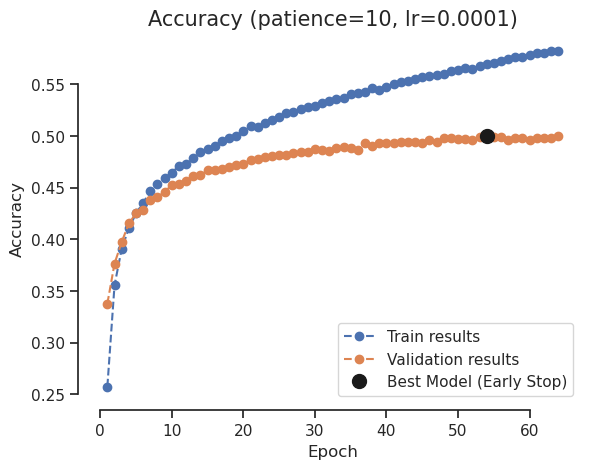


--- Best Performance ---
Stopped at epoch: 64
Best Validation Accuracy: 0.5000 at epoch 54


In [35]:
# number of hidden units

####################
lr= 1e-4

model_hu = MLP(
    img_width=32,
    num_in_channels=3,
    num_classes=10,
    num_hidden_units=60,
    num_hidden_layers=1
)
model_hu = model_hu.to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_hu.parameters(), lr=lr)


stopper_hu = EarlyStopper(verbose=True, path=checkpoint_path, patience=patience_val)


train_losses, val_losses, train_accs, val_accs, _ = run_training(
    model_hu,
    optimizer,
    loss_function,
    device,
    num_epochs,
    trainloader,
    valloader,
    early_stopper=stopper_hu,
    verbose=True
)


best_val_acc = stopper_hu.best_acc
best_val_acc_epoch = np.argmax(val_accs) + 1

plot(
    f"Accuracy (patience={patience_val}, lr={lr})",
    "Accuracy",
    train_accs,
    val_accs,
    extra_pt=(best_val_acc_epoch, best_val_acc),
    extra_pt_label="Best Model (Early Stop)"
)


print("\n--- Best Performance ---")
print(f"Stopped at epoch: {len(val_accs)}")
print(f"Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch}")

####################

Validation accuracy increased (0.2356). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.2845). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3190). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3408). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3538). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3635). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3715). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3855). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3928). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3967). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4040). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4069). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4133). Saving model

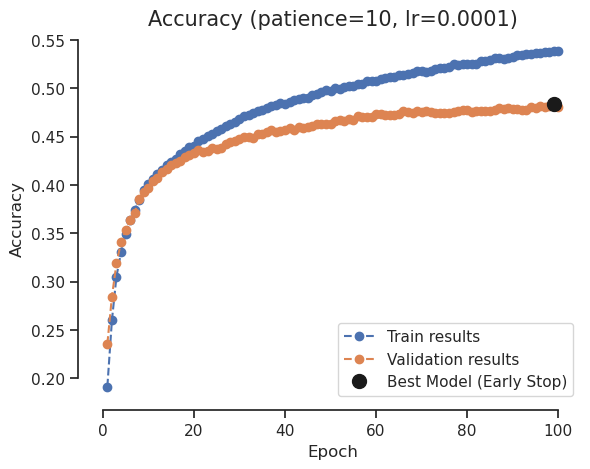


--- Best Performance ---
Stopped at epoch: 100
Best Validation Accuracy: 0.4838 at epoch 99


In [37]:
# number of layers

####################
lr= 1e-4

model_hl = MLP(
    img_width=32,
    num_in_channels=3,
    num_classes=10,
    num_hidden_units=30,
    num_hidden_layers=2
)
model_hl = model_hl.to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_hl.parameters(), lr=lr)


stopper_hl = EarlyStopper(verbose=True, path=checkpoint_path, patience=patience_val)


train_losses, val_losses, train_accs, val_accs, _ = run_training(
    model_hl,
    optimizer,
    loss_function,
    device,
    num_epochs,
    trainloader,
    valloader,
    early_stopper=stopper_hl,
    verbose=True
)


best_val_acc = stopper_hl.best_acc
best_val_acc_epoch = np.argmax(val_accs) + 1

plot(
    f"Accuracy (patience={patience_val}, lr={lr})",
    "Accuracy",
    train_accs,
    val_accs,
    extra_pt=(best_val_acc_epoch, best_val_acc),
    extra_pt_label="Best Model (Early Stop)"
)


print("\n--- Best Performance ---")
print(f"Stopped at epoch: {len(val_accs)}")
print(f"Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch}")
####################

#### Questions
- How good do you get?
- Which hyper-parameter makes the largest difference?
- Does it always help to make your model bigger (i.e. wider / deeper)? Why not?



**Your answers:**
- By doubling the hidden units, validation accuracy reaches 0.5 at epoch 54, while by adding one more hidden layer we get a validation accuracy of 0.48 at epoch 99.
- Here it seems that changing the size of the hidden units makes the largest difference.
- No, making our model bigger (i.e. wider / deeper) doesn't always help, beacause if we make it too wide or too deep it can start overfitting. 

Now, here are more TODO's, questions and a little challenge for you: 

#### TODO:
- If you choose your best values for number hidden units, number of layers and activation function that you determined by varying them independently above: Does performance improve? Why?
- Vary all of the parameters at the same time to maximize the predictive performance of your model. How good do you get?
    - When creating the exercise, I got a validation accuracy of 57%
    - Surpassing 50% val. acc. should be possible for you

Validation accuracy increased (0.3034). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3455). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3733). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.3925). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4032). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4137). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4206). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4243). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4330). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4378). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4423). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4461). Saving model to best_model_1e-4.pt ...
Validation accuracy increased (0.4475). Saving model

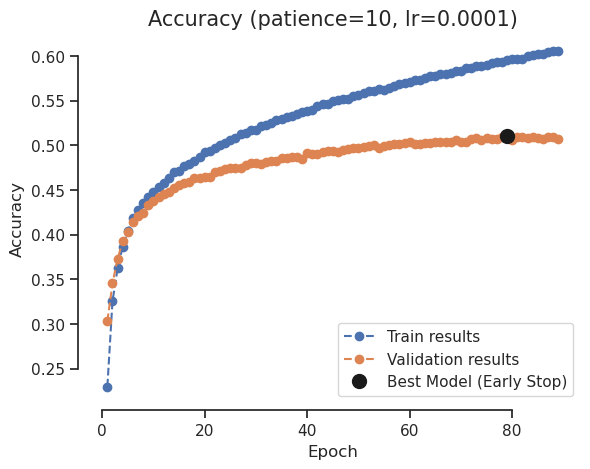


--- Best Performance ---
Stopped at epoch: 89
Best Validation Accuracy: 0.5104 at epoch 79


In [78]:
# Your best model:

####################
lr= 1e-4

best_model = MLP(
    img_width=32,
    num_in_channels=3,
    num_classes=10,
    num_hidden_units=60,
    num_hidden_layers=2
)
best_model = best_model.to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(best_model.parameters(), lr=lr)


stopper_bm = EarlyStopper(verbose=True, path=checkpoint_path, patience=patience_val)


train_losses, val_losses, train_accs, val_accs, _ = run_training(
    best_model,
    optimizer,
    loss_function,
    device,
    num_epochs,
    trainloader,
    valloader,
    early_stopper=stopper_bm,
    verbose=True
)


best_val_acc = stopper_bm.best_acc
best_val_acc_epoch = np.argmax(val_accs) + 1

plot(
    f"Accuracy (patience={patience_val}, lr={lr})",
    "Accuracy",
    train_accs,
    val_accs,
    extra_pt=(best_val_acc_epoch, best_val_acc),
    extra_pt_label="Best Model (Early Stop)"
)


print("\n--- Best Performance ---")
print(f"Stopped at epoch: {len(val_accs)}")
print(f"Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch}")
####################

#### Questions:
- If you train the same model multiple times from scratch: do you get the same performance? Are the models you trained above comparable then?
- What could we do about this?
    - *Hint:* there are actually multiple answers to this question. 
    - One could be to change model training and evaluation. How?
    - The other could be to use a more sophisticated analysis. How?

#### Answers:
- No, we don't get the same performance, sometimes it's better and sometimes worse. No they are not really comparable as the small fluctuations are just part of stochastic training.
- One could set random seeds to have reproducable results.



# Evaluate your best model on test set, once!

When doing a study, at the very end right before writing up your paper, you evaluate the best model you chose on the test set. This is the performance value you will report to the public.

#### TODO:
- What is the accuracy of the best model you found on the test set?
- Plot the confusion matrix, too!

In [79]:
def test(test_loader, model, device):
    """Compute accuracy and confusion matrix on test set.

    Args:
        test_loader (DataLoader): torch DataLoader of test set
        model (nn.Module): Model to evaluate on test set
        device (torch.device): Device to use

    Returns:
        float, torch.Tensor shape (10,10): Returns model accuracy on test set
            (percent classified correctly) and confusion matrix
    """
    ####################
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

    # Return the mean loss, the accuracy and the confusion matrix
    return accuracy(epoch_correct, epoch_total), confusion_matrix
    ####################

*Hint:* Use sklearn to create the confusion matrix ([link](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.confusion_matrix.html))

Best model's accuracy on the test set: 0.5008


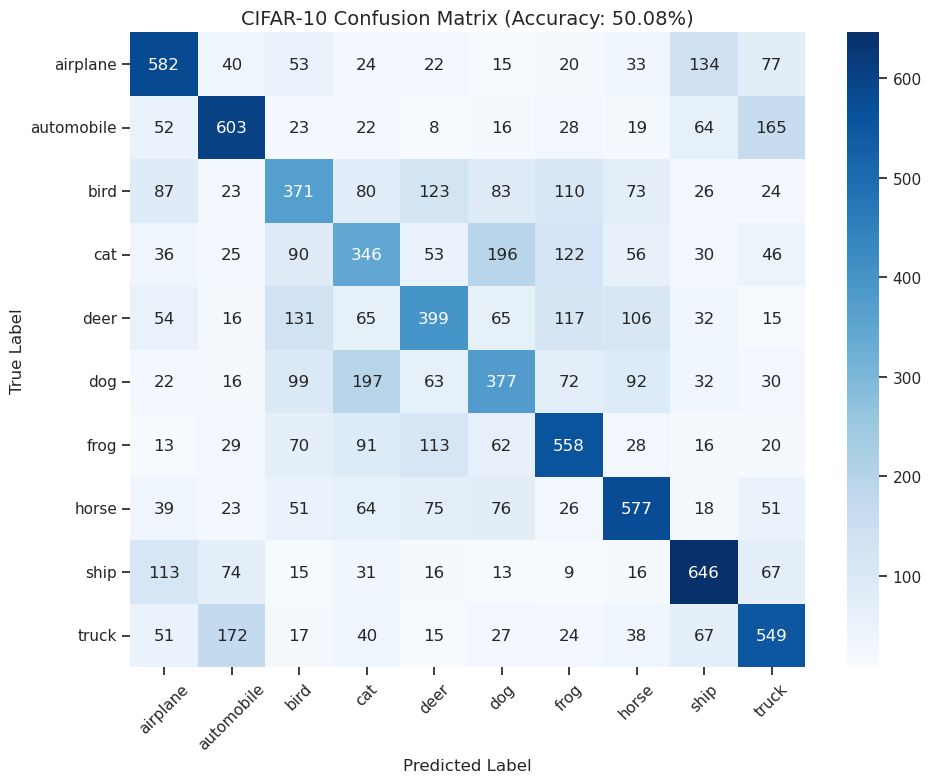

In [84]:
# The accuracy and confusion matrix

####################
acc, cf_matrix = test(testloader, best_model, device)

print(f"Best model's accuracy on the test set: {acc}")

class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

plt.figure(figsize=(10, 8))

sns.heatmap(
    cf_matrix,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title(f"CIFAR-10 Confusion Matrix (Accuracy: {acc:.2%})", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
####################

#### Questions:
- On which classes is your model's prediction poor?
- Is the test accuracy of your model as good as the validation accuracy?
- If those values are different: How can you explain the difference?
- Why should you never use test set performance when trying out different hyper-parameters and architectures?

#### Answers:
- The model's predictions for cats, dogs, birds and deers are poor. Cats are being confused for dogs and vice versa and birds for deers and vice versa.
- No, it's not, the test accuracy of our model is a bit lower than the validation accuracy.
- Our model is trained on the validation set and it 's trying to fit this data. Since it is learning from it, it is exprected that to fit it better than the test set, which is "unseen" data.
- Because if you are tuning your hyperparameters with your test set, you are biasing it towards the test set.

## How about the optimizer? _(Optional)_

_This task is optional, you do not need to solve it_

Now let's check out what difference it makes to use different optimizers in the learning strategy and what effect it has on the performance.

#### TODO *(Optional)*:

- Run training of the same model used above with
    - different optimizers (_hint_ - https://pytorch.org/docs/stable/optim.html)
- Compare your training results of all the different optimizer settings from above.
- What is your observation while using different optimizers? What is the respective impact on the model performance?

In [30]:
###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

## Explore batch size *(Optional)*

*This task is optional, you do not need to solve it*

Let us explore even more model and training parameters. In this section, we will see the impact of batch size on training. Let us use a learning rate of $10^{-3}$ from now on.


#### TODO *(Optional)*:
- Run training of the same model used above with 
    - batch size 1 for **one epoch**
    - batch size 512 for 100 epochs, using early stopping with patience 10
- Compare your training results of all three batch sizes you have trained, i.e. batch size 1, 512 and 1024 (from above)
- Was it smart to set batch size to 1?
- How long (in terms of computing time) do your models need to train for the different batch sizes? (You could even measure this with python, using the `time` package)
- What is the impact on model performance?

*Hint*: You have to initialize new data loaders, as they provide you with batches during training.

In [31]:
# Batch size 1

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

In [32]:
# Batch size 512

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

(OPTIONAL) You should evaluate on the test set with the optional solutions here (and see if they lead to performance gain).

In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials. You don't need to present the optional exercises

## Explore Activation Function _(Optional)_

*This task is optional, you do not need to solve it*

### TODO _(Optional)_:

Let's change activation function used (e.g. see [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity))
- Run training of the same model used above with a new activation function 
- Compare your training results

In [33]:
###############################
## YOUR CODE HERE - OPTIONAL ##
###############################